In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
configurationFile = './configurations/01_tgv.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [3]:
config

{'timestep': {'fixed': True},
 'domain': {'adjustParticle': False,
  'adjustDomain': False,
  'dim': 2,
  'periodic': True},
 'shifting': {'scheme': 'deltaSPH',
  'threshold': 0.05,
  'maxIterations': 1,
  'freeSurface': False},
 'sps': {'active': True},
 'diffusion': {'velocityScheme': 'deltaSPH_inviscid'},
 'plot': {'mosaic': 'AB',
  'figSize': [10, 5.5],
  'fps': 0,
  'updateInterval': 16,
  'export': False,
  'plots': {'A': {'quantity': 'index',
    'cbar': True,
    'cmap': 'twilight',
    'scaling': 'lin',
    's': 1,
    'gridVisualization': False,
    'title': 'Particle Index'},
   'B': {'quantity': 'velocities',
    'cbar': True,
    'cmap': 'viridis',
    'scaling': 'lin',
    'mapping': 'L2',
    's': 1,
    'gridVisualization': True,
    'title': '$|\\mathbf{u}|_2$',
    'streamLines': True}},
  'plotsAlt': {'B': {'quantity': 'velocities',
    'cbar': True,
    'cmap': 'icefire',
    'scaling': 'sym',
    'operation': 'curl',
    's': 1,
    'gridVisualization': True,
    '

In [4]:
nx = 128
L = 1
u_mag = 2
k = 1 * np.pi
TGV_override = False
targetRe = 2000

config['domain']['minExtent'] = -L
config['domain']['maxExtent'] =  L

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cuda'}
config['plot']['export'] = True
config['kernel'] = {'name': 'Wendland4'}
# config['kernel']['targetNeighbors'] = 100
# config['compute'] = {'device': 'cpu'}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)
config['integration']['scheme'] = 'symplecticEuler'

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


$\alpha = 0.00943240337073803$ is very low, consider increasing the value (should be > 0.01)
Re = 1999.9996337890625, $\nu_{sph} = 0.0020000003278255463$, $\alpha = 0.00943240337073803$


In [5]:
def sampleNoisyParticles(noiseConfig, config, sdfs = [], randomizeParticles = False):
    particlesA, volumeA = sampleRegular(config['particle']['dx'], config['domain']['dim'], config['domain']['minExtent'], config['domain']['maxExtent'], config['kernel']['targetNeighbors'], config['simulation']['correctArea'], config['kernel']['function'])
    particlesA = particlesA.to(config['compute']['device'])
    volumeA = volumeA.to(config['compute']['device'])
    
    area = (4 / config['particle']['nx']**2)
    area = volumeA
    grid, noiseSimplex = sampleNoise(noiseConfig)

    noiseState = {}
    noiseState['numParticles'] = particlesA.shape[0]
    # noiseState['timestep'] = 0
    # noiseState['time'] = 0.
    # noiseState['dt'] = config['timestep']['dt']
    noiseState['positions'] = particlesA
    noiseState['areas'] = particlesA.new_ones(particlesA.shape[0]) * area
    noiseState['pressures'] = particlesA.new_zeros(particlesA.shape[0])
    noiseState['divergence'] = particlesA.new_zeros(particlesA.shape[0])
    noiseState['masses'] = noiseState['areas'] * config['fluid']['rho0']
    noiseState['supports'] = volumeToSupport(area, config['kernel']['targetNeighbors'], config['domain']['dim']) * particlesA.new_ones(particlesA.shape[0])
    noiseState['index'] = torch.arange(particlesA.shape[0], device = particlesA.device)
    noiseState['densities'] = particlesA.new_ones(particlesA.shape[0]) * config['fluid']['rho0'] 
    noiseState['velocities'] = particlesA.new_zeros(particlesA.shape[0], config['domain']['dim'])
    noiseState['accelerations'] = particlesA.new_zeros(particlesA.shape[0], config['domain']['dim'])
    if len(sdfs) > 0:
        noiseState['distances'] = particlesA.new_ones(particlesA.shape[0]) * np.inf

    if randomizeParticles:
        baseShiftingConfig = copy.deepcopy(config['shifting'])

        config['shifting']['solver'] = 'BiCGStab_wJacobi'
        # config['shifting']['solver'] = 'BiCGStab'
        config['shifting']['maxIterations'] = 64
        config['shifting']['freeSurface'] = False
        config['shifting']['summationDensity'] = False
        config['shifting']['scheme'] = 'IPS'
        config['shifting']['maxSolveIter'] = 128
        config['shifting']['initialization'] = 'zero'
        config['shifting']['threshold'] = 0.5

        positions = torch.rand(noiseState['positions'].shape, device = noiseState['positions'].device) * 2 - 1
        shiftState = {
                'positions': positions,
                'areas': noiseState['areas'],
                'densities': noiseState['densities'],\
                'numParticles': noiseState['numParticles'],
                'velocities': noiseState['velocities'],
                'masses': noiseState['masses'],
                'supports': noiseState['supports'],
            }
        dx, states = solveShifting({
            'fluid':shiftState
        }, config)
        shiftState['positions'] = positions + dx

        config['shifting'] = baseShiftingConfig

        x = shiftState['positions'].clone()

        periodic = config['domain']['periodicity']
        minDomain = config['domain']['minExtent']
        maxDomain = config['domain']['maxExtent']
        periodicity = torch.tensor([False] * x.shape[1], dtype = torch.bool).to(x.device)
        if isinstance(periodic, torch.Tensor):
            periodicity = periodic
        if isinstance(periodic, bool):
            periodicity = torch.tensor([periodic] * x.shape[1], dtype = torch.bool).to(x.device)

        mod_positions = torch.stack([x[:,i] if not periodic_i else torch.remainder(x[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)
        lin_x = (mod_positions[:,0] - minDomain[0]) / (maxDomain[0] - minDomain[0])
        lin_y = (mod_positions[:,1] - minDomain[1]) / (maxDomain[1] - minDomain[1])

        gridDim = 128 // 2
        linearIndex = (torch.round(lin_x * gridDim) + torch.round(lin_y * gridDim) * gridDim).to(torch.int32)
        sortedIndices = torch.argsort(linearIndex)
        sortedPositions = mod_positions[sortedIndices]
        shiftState['positions'] = sortedPositions

        _, noiseNeighbors = neighborSearch(shiftState, noiseState, config)

        noise = noiseSimplex.flatten().to(particlesA.device)
        noiseState['potential'] = sphOperationStates(noiseState, shiftState, (noise, noise), operation = 'interpolate', neighborhood = noiseNeighbors)
        noiseState['positions'] = shiftState['positions']



    else:
        noiseState['potential'] = noiseSimplex.flatten().to(particlesA.device)




    # mask = torch.ones_like(noiseState['areas'], dtype = torch.bool)
    # fluid_sdfs = [sdf['sdf'] for sdf in sdfs if sdf['type'] == 'fluid' ]   
    # mask = None
    # if len(fluid_sdfs) > 0:
    #     mask = torch.zeros_like(noiseState['areas'], dtype = torch.bool)

    #     for sdf_func in fluid_sdfs:
    #         _, maskA, sdfValues, _ = filterParticlesWithSDF(particlesA, sdf_func, noiseState['supports'][0], -1e-4)
    #         mask = mask | maskA
    #         noiseState['distances'] = torch.min(noiseState['distances'], sdfValues)
    #     mask = mask.to(config['compute']['device'])
    # noiseState['velocities'][~mask, :] = 0

    samplings = None
    if samplings is None:   
        samplings = ['regular' for _ in sdfs]
    if not isinstance(samplings, List):
        samplings = [samplings for _ in sdfs]

    boundary_sdfs = [sdf['sdf'] for sdf in sdfs if sdf['type'] == 'boundary' ]   
    
    boundaryParticles, boundaryVolumes, boundaryDistances, boundaryNormals, boundaryBodyIDs, fluidMask = sampleBoundaryParticles(noiseState, boundary_sdfs, config, samplings)
    for k in noiseState.keys():
        if isinstance(noiseState[k], torch.Tensor):
            noiseState[k] = noiseState[k][fluidMask]
    noiseState['numParticles'] = noiseState['positions'].shape[0]
            
    _, fluidNeighborhood = neighborSearch(noiseState, noiseState, config)

    noiseState['neighborhood'] = fluidNeighborhood
    # printState(noiseState)
    
    # printState(noiseState)

    # for sdf in boundary_sdfs:
    #     # _, maskA, _, _ = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), config['particle']['support'], -1e-4)
        # noiseState['potential'] = filterPotentialField(operatorDict['invert'](sdf), noiseState, config, kind = 'divergenceFree')
        # noiseState['potential'] = filterPotentialField(sdf, noiseState, config, kind = 'divergenceFree')


    noiseState['velocities'], noiseState['divergence'] = sampleVelocityField(noiseState, noiseState['neighborhood'])
    # if mask is None:
        # mask = torch.ones_like(noiseState['potential'], dtype = torch.bool)
    # for sdf_func in boundary_sdfs:
        # _, maskA, _, _ = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), config['particle']['support'], -1e-4)
        # _, maskA, _, _ = filterParticlesWithSDF(particlesA, sdf, config['particle']['support'], -1e-4)
        # mask = mask & maskA
    # noiseState['velocities'][~mask, :] = 0

    _, noiseState['numNeighbors'] = countUniqueEntries(fluidNeighborhood['indices'][0], noiseState['positions'])

    return noiseState, None

In [6]:

from torch.profiler import profile, record_function, ProfilerActivity
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.plotting import plotRegions
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

inner = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([1 + config['particle']['dx'] * boundary_width,1 + config['particle']['dx'] * boundary_width]).to(points.device))
outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
boundary_sdf = operatorDict['invert'](inner)


fluid_sdf = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
# fluid_sdf = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/2, - 1/2]))


regions = [
    # {
    #     'sdf': inletSDF,
    #     'type': 'inlet',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    # {
    #     'sdf': inletSDF,
    #     'type': 'forcing',
    #     'forcingMode': 'immediate',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletSDF,
    #     'type': 'outlet',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletSDF])[0],
    #     'contour': find_contour(outletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletRegion,
    #     'type': 'mirror',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletRegion])[0],
    #     'contour': find_contour(outletRegion(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
{
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

config['regions'] = regions

# fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
# setPlotBaseAttributes(axis[0,0], config)
# # setPlotBaseAttributes(axis[0,1], config)

# # plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,0])


In [7]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

# particleState, mask = sampleParticles(config, sdfs = [])
particleState, mask = sampleNoisyParticles(config['noise'], config, sdfs = regions)

priorState = None
particleState['velocities'][:,0] =  u_mag * torch.cos(k * particleState['positions'][:,0]) * torch.sin(k * particleState['positions'][:,1])
particleState['velocities'][:,1] = -u_mag * torch.sin(k * particleState['positions'][:,0]) * torch.cos(k * particleState['positions'][:,1])

# u_max = torch.linalg.norm(particleState['velocities'], dim = 1).max()
# particleState['velocities'] = particleState['velocities'] / (u_max + 1e-7) * u_mag
Ek0 = 0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(particleState['velocities'], dim = -1)**2

initialVelocities = particleState['velocities'].clone()

particleState['Eks'] =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2)
particleState['E_k'] = particleState['Eks'].sum().cpu().detach().item()

# perennialState = {
#     'fluid': copy.deepcopy(particleState),
#     'time': 0.0,
#     'timestep': 0,
#     'dt': config['timestep']['dt'],
# }
# del particleState['neighborhood']


In [8]:
# baseShiftingConfig = copy.deepcopy(config['shifting'])

# config['shifting']['solver'] = 'BiCGStab_wJacobi'
# # config['shifting']['solver'] = 'BiCGStab'
# config['shifting']['maxIterations'] = 32
# config['shifting']['freeSurface'] = False
# config['shifting']['summationDensity'] = True
# config['shifting']['scheme'] = 'IPSn'
# config['shifting']['maxSolveIter'] = 128
# config['shifting']['initialization'] = 'deltaMinus'
# config['shifting']['threshold'] = 5

# positions = torch.rand(particleState['positions'].shape, device = particleState['positions'].device) * 2 - 1
# shiftState = {
#         'positions': positions,
#         'areas': particleState['areas'],
#         'densities': particleState['densities'],\
#         'numParticles': particleState['numParticles'],
#         'velocities': particleState['velocities'],
#         'masses': particleState['masses'],
#         'supports': particleState['supports'],
#     }

# dx, states = solveShifting({
#     'fluid':shiftState
# }, config)
# shiftState['positions'] = positions + dx
# config['shifting']['scheme'] = 'IPS'
# config['shifting']['maxIterations'] = 16
# dx, states = solveShifting({
#     'fluid':shiftState
# }, config)
# shiftState['positions'] = shiftState['positions'] + dx

# config['shifting'] = baseShiftingConfig

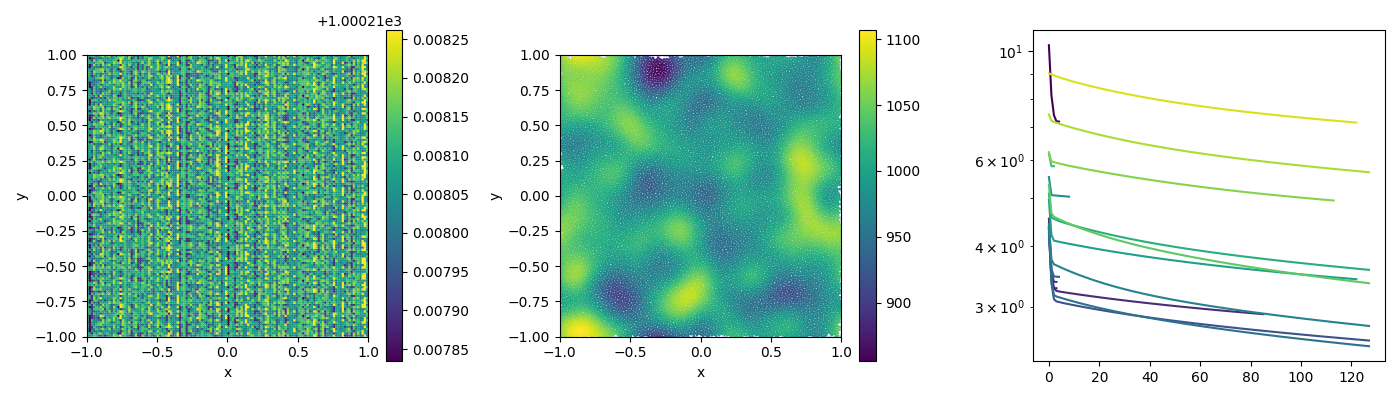

In [9]:
# from diffSPH.v2.modules.neighborhood import searchNeighbors
# from diffSPH.v2.plotting import setPlotBaseAttributes
# from diffSPH.v2.simulationSchemes.deltaPlus import callModule, computeDensity
# initialState = {
#     'fluid': particleState,
#     'time': 0.0,
#     'timestep': 0,
#     'dt': torch.tensor(5e-4, device = config['compute']['device']),
# }
# searchNeighbors(initialState, config)
# rho, _ = callModule(initialState, computeDensity, config)

# initialState = {
#     'fluid': shiftState,
#     'time': 0.0,
#     'timestep': 0,
#     'dt': torch.tensor(5e-4, device = config['compute']['device']),
# }
# searchNeighbors(initialState, config)
# rho2, _ = callModule(initialState, computeDensity, config)


# from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
# fig, axis = plt.subplots(1,3, figsize = (14,4), squeeze = False)

# visualizationState = prepVisualizationState(initialState, config, grid = True)
# # plotRegions(regions, axis[0,0])
# # plotRegions(regions, axis[0,1])

# s = 1

# setPlotBaseAttributes(axis[0,0], config)
# # setPlotBaseAttributes(axis[0,1], config)
# setPlotBaseAttributes(axis[0,1], config)


# sc = axis[0,0].scatter(particleState['positions'][:,0].cpu().detach().numpy(), particleState['positions'][:,1].cpu().detach().numpy(), s = s, c = rho.cpu().detach().numpy(), cmap = 'viridis')
# fig.colorbar(sc, ax = axis[0,0])

# # sc = axis[0,1].scatter(positions[:,0].cpu().detach().numpy(), positions[:,1].cpu().detach().numpy(), s = s, c = 'red', cmap = 'viridis')

# sc = axis[0,1].scatter(shiftState['positions'][:,0].cpu().detach().numpy(), shiftState['positions'][:,1].cpu().detach().numpy(), s = s, c = rho2.cpu().detach().numpy(), cmap = 'viridis')
# fig.colorbar(sc, ax = axis[0,1])

# # indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
# #                                       rho,
# #                                       mapping = 'L2', s = s, 
# #                           scaling = 'lin', gridVisualization=False, cmap = 'viridis', title = 'Velocity', which = 'fluid', plotBoth = False, midPoint = 0)

# # fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.2f}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum()}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$')

# viridis = plt.get_cmap('viridis') 
# norm = plt.Normalize(vmin=0, vmax=len(states)) 
# for i, (convergence, iters, residual) in enumerate(states):
#     # print(convergence)
#     axis[0,2].plot([c.cpu().item() for c in convergence], label = f'{iters} iters, {residual.cpu().item():.2e}', c = viridis(norm(i)))

# axis[0,2].set_yscale('log')

# fig.tight_layout()

In [10]:
# from diffSPH.v2.modules.viscosity import computeViscosity 
# from diffSPH.v2.modules.gravity import computeGravity
# from diffSPH.v2.modules.dfsph import dfsphSolve

# baseShiftingConfig = copy.deepcopy(config['shifting'])

# config['shifting']['solver'] = 'BiCGStab_wJacobi'
# # config['shifting']['solver'] = 'BiCGStab'
# config['shifting']['maxIterations'] = 64
# config['shifting']['freeSurface'] = False
# config['shifting']['summationDensity'] = True
# config['shifting']['scheme'] = 'IPSn'
# config['shifting']['maxSolveIter'] = 128
# config['shifting']['initialization'] = 'deltaMinus'
# config['shifting']['threshold'] = 5

# positions = torch.rand(particleState['positions'].shape, device = particleState['positions'].device) * 2 - 1
# shiftState = {
#         'positions': positions,
#         'areas': particleState['areas'],
#         'densities': particleState['densities'],\
#         'numParticles': particleState['numParticles'],
#         'velocities': particleState['velocities'],
#         'masses': particleState['masses'],
#         'supports': particleState['supports'],
#     }

# dx, states = solveShifting({
#     'fluid':shiftState
# }, config)
# shiftState['positions'] = positions + dx
# config['shifting']['scheme'] = 'IPS'
# config['shifting']['maxIterations'] = 16
# dx, states = solveShifting({
#     'fluid':shiftState
# }, config)
# shiftState['positions'] = shiftState['positions'] + dx

# config['shifting'] = baseShiftingConfig
# initialState = {
#     'fluid': shiftState,
#     'time': 0.0,
#     'timestep': 0,
#     'dt': torch.tensor(5e-4, device = config['compute']['device']),
# }

Iteration 1, rho = 1000.90283203125 Iterations: 48, residual: 5.913964741921518e-06
Iteration 2, rho = 1000.76171875 Iterations: 48, residual: 5.919072918914026e-06
Iteration 3, rho = 1000.6168823242188 Iterations: 48, residual: 5.608950232272036e-06
Iteration 4, rho = 1000.5457763671875 Iterations: 48, residual: 5.149324351805262e-06
Iteration 5, rho = 1000.5360107421875 Iterations: 48, residual: 4.629624072549632e-06
Iteration 6, rho = 1000.5362548828125 Iterations: 48, residual: 4.1352968764840625e-06
Iteration 7, rho = 1000.5147705078125 Iterations: 48, residual: 3.707230007421458e-06
Iteration 8, rho = 1000.4757080078125 Iterations: 48, residual: 3.3512262689328054e-06
Iteration 9, rho = 1000.4384765625 Iterations: 48, residual: 3.0620362849731464e-06
Iteration 10, rho = 1000.4151000976562 Iterations: 48, residual: 2.8212111828906927e-06
Iteration 11, rho = 1000.4033203125 Iterations: 48, residual: 2.6145426090806723e-06
Iteration 12, rho = 1000.394775390625 Iterations: 48, residu

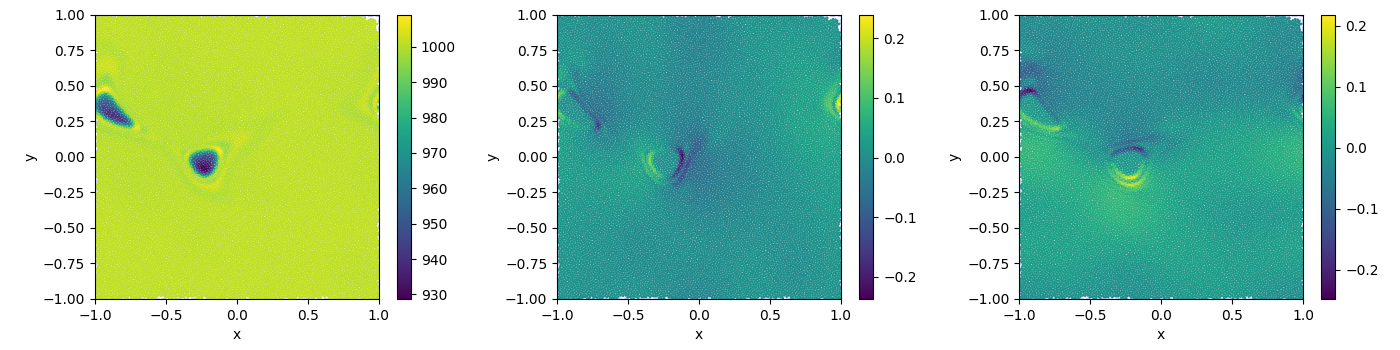

In [11]:
# state = copy.deepcopy(initialState)
# k = 1 * np.pi
# state['fluid']['velocities'][:,0] =  0 * torch.cos(k * state['fluid']['positions'][:,0]) * torch.sin(k * state['fluid']['positions'][:,1])
# state['fluid']['velocities'][:,1] = -0 * torch.sin(k * state['fluid']['positions'][:,0]) * torch.cos(k * state['fluid']['positions'][:,1])

# config['dfsph']['maxIters'] = 48
# config['dfsph']['errorThreshold'] = 1e-5/ config['fluid']['rho0']
# config['dfsph']['omega'] = 0.3
# config['dfsph']['sourceTerm'] = 'density'

# i = 0
# while(True):
#     i += 1
#     searchNeighbors(state, config)

#     state['fluid']['densities'], _ = callModule(state, computeDensity, config, 'fluid')
#     # print(f'Iteration {i}, rho = {state["fluid"]["densities"].mean()}')
#     state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
#     state['fluid']['gravityAccel'] = computeGravity(state['fluid'], config)
#     state['fluid']['gravityAccel'] = state['fluid']['gravityAccel'] * 0
#     state['fluid']['advection'] = state['fluid']['gravityAccel'] + state['fluid']['velocityDiffusion']
#     state['fluid']['pressureAccel'], _ = callModule(state, dfsphSolve, config, 'fluid')
#     dudt = state['fluid']['pressureAccel'] + state['fluid']['gravityAccel'] + state['fluid']['velocityDiffusion']

#     state['fluid']['accelerations'] = dudt
#     state['fluid']['velocities'] = state['fluid']['velocities'] + state['fluid']['accelerations'] * state['dt']
#     state['fluid']['positions'] = state['fluid']['positions'] + state['fluid']['velocities'] * state['dt']
#     state['fluid']['velocities'] = state['fluid']['velocities'] * 0.5
#     print(f'Iteration {i}, rho = {state["fluid"]["densities"].mean()} Iterations: {len(state["fluid"]["convergence_density"])}, residual: {state["fluid"]["convergence_density"][-1]}')
#     if state["fluid"]["convergence_density"][-1] < 1e-3 / config['fluid']['rho0']:
#         break


# from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
# fig, axis = plt.subplots(1,3, figsize = (14,3.5), squeeze = False)

# visualizationState = prepVisualizationState(initialState, config, grid = True)
# # plotRegions(regions, axis[0,0])
# # plotRegions(regions, axis[0,1])

# s = 1

# setPlotBaseAttributes(axis[0,0], config)
# setPlotBaseAttributes(axis[0,1], config)
# setPlotBaseAttributes(axis[0,2], config)


# sc = axis[0,0].scatter(state['fluid']['positions'][:,0].cpu().detach().numpy(), state['fluid']['positions'][:,1].cpu().detach().numpy(), s = s, c = state['fluid']['densities'].cpu().detach().numpy(), cmap = 'viridis')
# fig.colorbar(sc, ax = axis[0,0])

# # sc = axis[0,1].scatter(positions[:,0].cpu().detach().numpy(), positions[:,1].cpu().detach().numpy(), s = s, c = 'red', cmap = 'viridis')

# sc = axis[0,1].scatter(state['fluid']['positions'][:,0].cpu().detach().numpy(), state['fluid']['positions'][:,1].cpu().detach().numpy(), s = s, c = state['fluid']['velocities'][:,0].cpu().detach().numpy(), cmap = 'viridis')
# fig.colorbar(sc, ax = axis[0,1])

# sc = axis[0,2].scatter(state['fluid']['positions'][:,0].cpu().detach().numpy(), state['fluid']['positions'][:,1].cpu().detach().numpy(), s = s, c = state['fluid']['velocities'][:,1].cpu().detach().numpy(), cmap = 'viridis')
# fig.colorbar(sc, ax = axis[0,2])


# fig.tight_layout()

In [12]:
config['plot']['plots']['A']['quantity'] = 'densities'

In [13]:

from diffSPH.v2.math import scatter_sum
from typing import Union
@torch.jit.script 
def sphDivergence(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], gradKernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int, type : str = 'naive', mode : str = 'div'):    # Ancillary information
    i = neighborhood[0]                                                    
    j = neighborhood[1]

    assert (isinstance(quantities, tuple) and quantities[0].dim() > 1) or (isinstance(quantities, torch.Tensor) and quantities.dim() > 1), 'Cannot compute divergence on non vector fields!'
    assert (mode in ['div','dot']), 'Only supports div F and nabla dot F'

    if type == 'symmetric':
        assert isinstance(quantities, tuple), 'Symmetric divergence only supports two inputs for quantities!'
        k = masses[1][j].view(-1,1) * gradKernels
        Ai = torch.einsum('n..., n -> n...', quantities[0][i], 1.0 / densities[0][i]**2)
        Aj = torch.einsum('n..., n -> n...', quantities[1][j], 1.0 / densities[1][j]**2)
        q = Ai + Aj
            
        if mode == 'div':
            kq = torch.einsum('n...d, nd -> n...', q, k)
        else:
            kq = torch.einsum('nd..., nd -> n...', q, k)

        return torch.einsum('n, n... -> n...', densities[0], scatter_sum(kq, i, dim = 0, dim_size = numParticles))
        
    q = quantities[1][j] if isinstance(quantities, tuple) else quantities
    k = (masses[1][j] / densities[1][j]).view(-1,1) * gradKernels
    
    if type == 'difference':
        q = (quantities[1][j] - quantities[0][i]) if isinstance(quantities, tuple) else quantities
    elif type == 'summation':
        q = (quantities[1][j] + quantities[0][i]) if isinstance(quantities, tuple) else quantities
        
    if mode == 'div':
        kq = torch.einsum('n...d, nd -> n...', q, k)
    else:
        kq = torch.einsum('nd..., nd -> n...', q, k)
            
    
    return scatter_sum(kq, i, dim = 0, dim_size = numParticles)

In [14]:
import torch
from diffSPH.v2.sphOps import sphOperationStates
from torch.profiler import record_function

def computeMomentumEquation(stateA, stateB, neighborhood, config):
    with record_function("[SPH] - Fluid Momentum (rho_i nabla cdot v)"):

        # div = sphDivergence((stateA['masses'].to(torch.float64), stateB['masses'].to(torch.float64)), (stateA['densities'].to(torch.float64), stateB['densities'].to(torch.float64)), (stateA['velocities'].to(torch.float64), stateB['velocities'].to(torch.float64)), neighborhood, config['kernel']['gradKernels'].to(torch.float64), stateA['numParticles'], type = 'difference', mode = 'div')

        # return -(stateA['densities'] * div).to(torch.float32)# sphOperationStates(stateA, stateB, (stateA['velocities'], stateB['velocities']), operation = 'divergence', gradientMode='difference', neighborhood=neighborhood)
        numParticles = stateA['numParticles']
        i,j = neighborhood['indices']
        u_i = stateA['velocities'][i]#.to(torch.float64)
        u_j = stateB['velocities'][j]#.to(torch.float64)

        rho_j = stateB['densities'][j]

        q_ij = (u_j - u_i) * stateA['masses'][j].view(-1,1)
        # q_ij = (u_j - u_i) * stateA['masses'][j].to(torch.float64).view(-1,1)

        k = neighborhood['gradients']#.to(torch.float64)
        kq = torch.einsum('n...d, nd -> n...', q_ij, k)

        kqa = q_ij[:,0] * k[:,0]
        kqb = q_ij[:,1] * k[:,1]
        kq = kqa + kqb        

        kq = kq * stateA['densities'][i] / stateB['densities'][j]
        div = -scatter_sum(kq, i, dim = 0, dim_size = numParticles)#.to(torch.float32)

        # print(f'q_ij: {q_ij.sum()} [{q_ij[:,0].sum()}, {q_ij[:,1].sum()}], k: {k.sum()} [{k[:,0].sum()}, {k[:,1].sum()}], kq: {kq.sum()} [{kqa.sum()}, {kqb.sum()}], div: {div.sum()}')

        # test_q_ij = (u_i - u_j) * stateA['masses'][j].to(torch.float64).view(-1,1)
        # test_kq = torch.einsum('n...d, nd -> n...', test_q_ij, -k)

        # print(torch.all(kq == test_kq))

        return div
        return -sphOperationStates(stateA, stateB, 
            q_ij, operation = 'divergence', gradientMode='difference', neighborhood=neighborhood)


In [15]:

def computeViscosity(stateA, stateB, neighborhood, config):
    with record_function("[SPH] - Fluid Viscosity [deltaSPH inviscid]"):
        # return viscosityKernel_cpp(
        #     neighborhood['indices'], neighborhood['supports'], neighborhood['kernels'], neighborhood['gradients'], neighborhood['distances'], neighborhood['vectors'], 
        #     stateA['numParticles'],
        #     neighborhood['numNeighbors'],
        #     neighborhood['neighborOffsets'],


        #     (stateA['velocities'], stateB['velocities']), 
        #     (stateA['densities'], stateB['densities']), 
        #     (stateA['masses'], stateB['masses']), 
        #     (stateA['supports'], stateB['supports']), 
        #     config['fluid']['cs'], config['fluid']['rho0'], config['diffusion']['alpha'], config['diffusion']['eps'], config['diffusion']['pi-switch'])

        eps = config['diffusion']['eps']
        alpha = config['diffusion']['alpha']

        (i,j) = neighborhood['indices']
        h_ij = neighborhood['supports']
        v_ij = stateA['velocities'][i] - stateB['velocities'][j]
        r_ij = neighborhood['distances'] * h_ij
        x_ij = neighborhood['vectors']# * r_ij.view(-1,1)
        vr_ij = torch.einsum('ij,ij->i', v_ij, x_ij)

        pi_ij = -vr_ij / (r_ij**2 + eps * h_ij**2)


        rho_ij = (stateA['densities'][i] + stateB['densities'][j]) / 2

        q = pi_ij * stateB['masses'][j] / rho_ij
        kq = q.view(-1,1) * neighborhood['gradients']

        visco = (alpha * stateA['supports'] * config['fluid']['cs'] * config['fluid']['rho0'] / stateA['densities']).view(-1,1)

        return visco * scatter_sum(kq, i, dim = 0, dim_size = stateA['numParticles'])

        # if config['diffusion']['pi-switch']:
            # pi_ij = torch.where(vr_ij < 0, pi_ij, 0)

        V_j = stateB['masses'][j] /( stateA['densities'][i] +  stateB['densities'][j])
        # if 'normals' in stateB:
        #     boundaryNormals = stateB['normals'][j]
        #     v_ij_parallel = torch.einsum('ij,ij->i', v_ij, boundaryNormals).view(-1,1) * boundaryNormals
        #     v_ij_orthogonal = v_ij - v_ij_parallel

        #     vr_ij = torch.einsum('ij,ij->i', vr_ij, x_ij)

        #     pi_ij = vr_ij / (r_ij + eps * h_ij**2)
        #     if config['diffusion']['pi-switch']:
        #         pi_ij = torch.where(vr_ij < 0, pi_ij, 0)

        # kq = (V_j * pi_ij).view(-1,1) * neighborhood['gradients']
        viscosityTerm =  (alpha * stateA['supports'] * config['fluid']['cs'] * config['fluid']['rho0'] / stateA['densities']).view(-1,1) * scatter_sum(kq, i, dim = 0, dim_size = stateA['numParticles'])
    


        return viscosityTerm
        # return (alpha * fluidState['fluidSupports'] * config['fluid']['cs'] * config['fluid']['rho0'] / fluidState['densities']).view(-1,1) * scatter_sum(kq, i, dim = 0, dim_size = fluidState['numParticles'])


In [16]:
from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.sphOps import sphOperationStates
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationStates
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.gravity import computeGravity
from diffSPH.v2.modules.sps import computeSPSTurbulence
from torch.profiler import record_function


from diffSPH.v2.modules.density import computeDensity
import torch
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.normalizationMatrices import computeCovarianceMatrices

def callModule(state, module, config, direction = 'all', reduce = 'sum', **kwargs):
    if not config['boundary']['active']:
        return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
    if direction == 'all':
        if not config['boundary']['active']:
            return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
        else:
            ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
            # print(f' fluid -> fluid: {ftf.shape}, mean: {ftf.mean()}, min: {ftf.min()}, max: {ftf.max()}')
            btb = module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
            # print(f' boundary -> boundary: {btb.shape}, mean: {btb.mean()}, min: {btb.min()}, max: {btb.max()}')
            btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
            # print(f' boundary -> fluid: {btf.shape}, mean: {btf.mean()}, min: {btf.min()}, max: {btf.max()}')
            ftb = module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
            # print(f' fluid -> boundary: {ftb.shape}, mean: {ftb.mean()}, min: {ftb.min()}, max: {ftb.max()}')

            if reduce == 'sum':
                return ftf + btf, btb + ftb
            elif reduce == 'min':
                return torch.min(ftf, btf), torch.min(btb, ftb)
            elif reduce == 'max':
                return torch.max(ftf, btf), torch.max(btb, ftb)
            else:
                raise ValueError(f"Invalid reduce {reduce}")
            
    if direction == 'fluid':
        return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
    if direction == 'fluidwBoundary':
        ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
        btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return ftf + btf, None
        elif reduce == 'min':
            return torch.min(ftf, btf), None
        elif reduce == 'max':
            return torch.max(ftf, btf), None
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    if direction == 'boundary':
        return None, module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
    if direction == 'boundarywFluid':
        btb = module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
        ftb = module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return None, btb + ftb
        elif reduce == 'min':
            return None, torch.min(btb, ftb)
        elif reduce == 'max':
            return None, torch.max(btb, ftb)
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    if direction == 'fluidToBoundary':
        return None, module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
    if direction == 'boundaryToFluid':
        return module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs), None
    if direction == 'oneWay':
        ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
        btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return ftf + btf, None
        elif reduce == 'min':
            return torch.min(ftf, btf), None
        elif reduce == 'max':
            return torch.max(ftf, btf), None
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    raise ValueError(f"Invalid direction {direction}")


from diffSPH.v2.simulationSchemes.deltaPlus import callModule
from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.sphOps import sphOperationStates, LiuLiuConsistent
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationStates
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm, densityGradient
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
# from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.gravity import computeGravity
from diffSPH.v2.modules.sps import computeSPSTurbulence
from torch.profiler import record_function


from diffSPH.v2.modules.density import computeDensity
import torch
from diffSPH.v2.modules.neighborhood import neighborSearch, searchNeighbors
from diffSPH.v2.modules.normalizationMatrices import computeCovarianceMatrices
# from diffSPH.v2.modules.inletOutlet import buildOutletGhostParticles
from diffSPH.v2.modules.mDBC import buildBoundaryGhostParticles, mDBCDensity
from diffSPH.v2.modules.inletOutlet import buildOutletGhostParticles



def computePressureAccelNonConservative(stateA, stateB, neighborhood, config):
    with record_function("[SPH] - Pressure Acceleration (1/rho nabla p)"):
        (i,j) = neighborhood['indices']
        p_i = stateA['pressures'][i]
        p_j = stateB['pressures'][j]
        p_ij = p_j - p_i
        # p_ij = p_j + p_i

        masses = (stateA['masses'], stateB['masses'])
        densities = (stateA['densities'], stateB['densities'])
        i, j = neighborhood['indices']
        gradKernels = neighborhood['gradients']
        numParticles = stateA['numParticles']

        k = (masses[1][j] / (densities[0][i] * densities[1][j] )).view(-1,1) * gradKernels
        qij = p_ij
        kq = torch.einsum('n... , nd -> n...d', qij, k)

        return -scatter_sum(kq, i, dim = 0, dim_size = numParticles)

        return -sphOperationStates(stateA, stateB, p_ij, operation = 'gradient', gradientMode='summation') / stateA['densities'].view(-1,1)
        return -sphOperationStates(stateA, stateB, (stateA['pressures'], stateB['pressures']), operation = 'gradient', gradientMode='summation', neighborhood= neighborhood) / stateA['densities'].view(-1,1)
    

def checkNaNs(state):
    for key in state:
        if isinstance(state[key], torch.Tensor):
            if torch.any(torch.isnan(state[key])):
                print(f'NaNs in {key}')
                raise RuntimeError(f'NaNs in {key}')
        if not isinstance(state[key], dict):
            continue
        for subkey in state[key]:
            if not isinstance(state[key][subkey], torch.Tensor):
                continue
            if torch.any(torch.isnan(state[key][subkey])):
                print(f'NaNs in {key} - {subkey}')
                raise RuntimeError(f'NaNs in {key} - {subkey}')
def checkNaN(tensor, name):
    if torch.any(torch.isnan(tensor)):
        print(f'NaNs in {name}, number of NaNs: {torch.sum(torch.isnan(tensor))}')
        raise RuntimeError(f'NaNs in {name}, number of NaNs: {torch.sum(torch.isnan(tensor))}')

def simulationStep(state, config):
    if config['compute']['checkNaN']:
        checkNaNs(state)


    with record_function("[SPH] - deltaSPH (1 - Neighbor Search)"):
        searchNeighbors(state, config)
        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (2 - Ghost Particle Creation)"):
        if config['boundary']['active'] and 'boundary' in state:
            state['boundaryGhost'] = buildBoundaryGhostParticles(state, config)
        if 'regions' in  config and config['regions'] is not None:
            state['outletGhost'] = buildOutletGhostParticles(config['regions'], state, config)
        # torch.cuda.synchronize()
        
    with record_function("[SPH] - deltaSPH (3 - Density Computation)"):
        if config['simulation']['densityScheme'] == 'summation':
            if config['boundary']['active']:
                state['fluid']['densities'], state['boundary']['densities'] = callModule(state, computeDensity, config, 'all')
            else:
                state['fluid']['densities'], _ = callModule(state, computeDensity, config, 'fluid')
            torch.cuda.synchronize()
        # print(f'Density Min: {state["fluid"]["densities"].min()}, Max: {state["fluid"]["densities"].max()}')
        if config['boundary']['active']:
            with record_function("[SPH] - deltaSPH (3 - mDBC Density Estimate)"):
                state['boundary']['densities'], state['boundaryGhost']['densities'] = mDBCDensity(state, config)
                # state['boundary']['densities'] += torch.abs(state['boundary']['distances']) / config['particle']['support'] * 2
                # torch.cuda.synchronize()
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['densities'], 'densities')
        if config['boundary']['active']:
            if config['compute']['checkNaN']:
                checkNaN(state['boundary']['densities'], 'boundary - densities')
    if 'regions' in config and config['regions'] is not None:
        if state['outletGhost'] is not None:
            with record_function("[SPH] - deltaSPH (4 - Outlet Processing)"):
                ghostState = state['outletGhost']
                neighbors = ghostState['neighborhood']['indices'][0]
                solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['densities'])

                cond = torch.logical_and(ghostState['numNeighbors'] >= 1, ghostState['sdf_dist'] < 2.5 * config['particle']['support'])
                cond = ghostState['numNeighbors'] >= 10

                def updateQuantity(state, ghostState, quantity, solution, cond):
                    return torch.where(cond, solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:]), quantity)
                state['fluid']['densities'][ghostState['fluidIndex']] = updateQuantity(state, ghostState, state['fluid']['densities'][ghostState['fluidIndex']], solution, cond)
                state['fluid']['outletMarker'] = state['fluid']['densities'].new_zeros(state['fluid']['densities'].shape[0])
                state['fluid']['outletMarker'][ghostState['fluidIndex']] = 1

                solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,0])
                state['fluid']['velocities'][ghostState['fluidIndex'],0] = updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,0], solution, cond)

                
                solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,1])
                state['fluid']['velocities'][ghostState['fluidIndex'],1] =updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,1], solution, cond)

                if config['compute']['checkNaN']:
                    checkNaN(state['fluid']['densities'], 'densities')
                    checkNaN(state['fluid']['velocities'], 'velocities')
                

                # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (5 - Normalization Matrices)"):
        # state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
        state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['covarianceMatrix'], 'covarianceMatrix')
        state['fluid']['covarianceMatrix'][state['fluid']['numNeighbors'] < 4,:,:] = torch.eye(2, dtype = state['fluid']['covarianceMatrix'].dtype, device = state['fluid']['covarianceMatrix'].device)[None,:,:]


        state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(state['fluid']['covarianceMatrix'])
    
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['L'], 'L')
            checkNaN(state['fluid']['L.EVs'], 'L.EVs')

        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (6 - Density Gradient)"):
        state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['gradRho^L'], 'gradRho^L')

        if config['boundary']['active']:
            state['fluid']['gradRho^L'] += callModule(state, densityGradient, config, 'boundaryToFluid')[0]


        # state['boundary']['gradRho^L'] = callModule(state, densityGradient, config, 'boundary')[1]
        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (7 - Diffusion and Momentum)"):
        state['fluid']['densityDiffusion'], _ = callModule(state, computeDensityDeltaTerm, config, 'fluid')
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['densityDiffusion'], 'densityDiffusion')
        # config['diffusion']['densityScheme'] = 'deltaSPH
        # state['fluid']['densityDiffusion'] += callModule(state, computeDensityDeltaTerm, config, 'boundaryToFluid')[0]

        # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
        # torch.cuda.synchronize()
        if config['boundary']['active']:
            # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
            state['fluid']['velocityDiffusion'], state['boundary']['velocityDiffusion'] = callModule(state, computeViscosity, config, 'fluid')
            if config['compute']['checkNaN']:
                checkNaN(state['fluid']['velocityDiffusion'], 'velocityDiffusion')
                # checkNaN(state['boundary']['velocityDiffusion'], 'boundary - velocityDiffusion')

            state['fluid']['momentumEquation'], state['boundary']['momentumEquation'] = callModule(state, computeMomentumEquation, config, 'all')
            if config['compute']['checkNaN']:
                checkNaN(state['fluid']['momentumEquation'], 'momentumEquation')
                # checkNaN(state['boundary']['momentumEquation'], 'boundary - momentumEquation')
        else:
            state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
            if config['compute']['checkNaN']:
                checkNaN(state['fluid']['velocityDiffusion'], 'velocityDiffusion')

            state['fluid']['momentumEquation'], _ = callModule(state, computeMomentumEquation, config, 'fluid')
            if config['compute']['checkNaN']:
                checkNaN(state['fluid']['momentumEquation'], 'momentumEquation')
        # torch.cuda.synchronize()
        state['fluid']['pressures'] = computeEOS(state['fluid'], config)
        if config['compute']['checkNaN']:
                checkNaN(state['fluid']['pressures'], 'pressures')

        if 'boundary' in state:
            state['boundary']['pressures'] = computeEOS(state['boundary'], config)
            if config['compute']['checkNaN']:
                checkNaN(state['boundary']['pressures'], 'boundary - pressures')

    with record_function("[SPH] - deltaSPH (8 - Pressure Forces)"):
        if 'boundary' in state:
            state['fluid']['pressureAccel'], state['boundary']['pressureAccel'] = callModule(state, computePressureAccel, config, 'all')
            state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccelNonConservative, config, 'fluid')
            if config['compute']['checkNaN']:
                # print(f'Pressure Min: {state["fluid"]["pressureAccel"].min()}, Max: {state["fluid"]["pressureAccel"].max()}')
                # print(f'Density Min: {state["fluid"]["densities"].min()}, Max: {state["fluid"]["densities"].max()}')
                # if 'outletMarker' in state['fluid']:
                #     print('In Mask:')
                #     print(f'Pressure Min: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 1].min()}, Max: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 1].max()}')
                #     print(f'Density Min: {state["fluid"]["densities"][state["fluid"]["outletMarker"] == 1].min()}, Max: {state["fluid"]["densities"][state["fluid"]["outletMarker"]== 1].max()}')

                #     print('Out Mask:')
                #     print(f'Pressure Min: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 0].min()}, Max: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 0].max()}')
                #     print(f'Density Min: {state["fluid"]["densities"][state["fluid"]["outletMarker"] == 0].min()}, Max: {state["fluid"]["densities"][state["fluid"]["outletMarker"] == 0].max()}')


                checkNaN(state['fluid']['pressureAccel'], 'pressureAccel')
                checkNaN(state['boundary']['pressureAccel'], 'boundary - pressureAccel')
        else:
            state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccel, config, 'fluid')
            state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccelNonConservative, config, 'fluid')
            checkNaN(state['fluid']['pressureAccel'], 'pressureAccel')
        # torch.cuda.synchronize()
    # state['fluid']['divergence'], state['boundary']['divergence'] = callModule(state, computePressureAccel, config, 'all')

    with record_function("[SPH] - deltaSPH (9 - External Forcing)"):
        state['fluid']['gravityAccel'] = computeGravity(state['fluid'], config)
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['gravityAccel'], 'gravityAccel')
        # torch.cuda.synchronize()

    # if config['SPS']['active']:
    #     with record_function("[SPH] - deltaSPH (7 - SPS Turbulence)"):
    #         state['fluid']['fluidSPSTurbulence'] = computeSPSTurbulence(simulationState, config)
    # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (10 - Integration)"):
        dudt = state['fluid']['pressureAccel'] + state['fluid']['gravityAccel'] + state['fluid']['velocityDiffusion']
        drhodt = state['fluid']['momentumEquation'] + state['fluid']['densityDiffusion']

        print('Momentum Term: Mean - ', state['fluid']['momentumEquation'].mean(), 'Max - ', state['fluid']['momentumEquation'].max(), 'Min - ', state['fluid']['momentumEquation'].min(), 'Sum: ', state['fluid']['momentumEquation'].sum())
        print('Density Term: Mean - ', state['fluid']['densityDiffusion'].mean(), 'Max - ', state['fluid']['densityDiffusion'].max(), 'Min - ', state['fluid']['densityDiffusion'].min(), 'Sum: ', state['fluid']['densityDiffusion'].sum())
        

        if config['compute']['checkNaN']:
            checkNaN(dudt, 'dudt')
            checkNaN(drhodt, 'drhodt')
        

        if 'regions' in config and  config['regions'] is not None:
            if state['outletGhost'] is not None:
                dudt[ghostState['fluidIndex'],:] = 0
                drhodt[ghostState['fluidIndex']] = 0

                    
                # bi = torch.unique(state['boundaryToFluidNeighborhood']['indices'][0])
                # oi = state['outletGhost']['fluidIndex']

                # hasBoundaryNeighbors = torch.zeros(state['fluid']['numParticles'], dtype = torch.bool, device = state['fluid']['positions'].device)
                # hasBoundaryNeighbors[bi] = True

                # hasOutletNeighbors = torch.zeros(state['fluid']['numParticles'], dtype = torch.bool, device = state['fluid']['positions'].device)
                # hasOutletNeighbors[oi] = True

                # mask = torch.logical_and(hasOutletNeighbors, hasBoundaryNeighbors)
                # indices = torch.arange(state['fluid']['numParticles'], device = state['fluid']['positions'].device)[mask]

                # # print(indices)

                # projectedVelocities = state['fluid']['velocities'].clone()
                # normal = torch.Tensor([0.,1.]).to(projectedVelocities.device)
                # projectedVelocities[indices] = projectedVelocities[indices] - torch.einsum('n, d -> nd', torch.einsum('nd, d -> n', state['fluid']['velocities'][indices], normal), normal)

                # dudt_ = -(projectedVelocities - state['fluid']['velocities']) / state['timestep']
                # dudt[indices] = dudt_[indices]
                # # state['fluid']['velocities'][indices] = projectedVelocities[indices] - torch.einsum('n, d -> nd', torch.einsum('nd, d -> n', state['fluid']['velocities'][indices], normal), normal)



        if 'boundary' not in state:
            return (state['fluid']['velocities'].clone(), dudt, drhodt), (None, None, None)
        # torch.cuda.synchronize()   
        boundary_dudt = state['boundary']['pressureAccel'] #+ state['boundary']['velocityDiffusion']
        boundary_drhodt = torch.zeros_like(state['boundary']['densities'])#state['boundary']['momentumEquation'] *0

        return (state['fluid']['velocities'].clone(), dudt, drhodt), (state['boundary']['velocities'].clone(), None, boundary_drhodt)
# from diffSPH.parameter import Parameter
# def getParameters():
#     return [
#         Parameter('deltaSPH', 'pressureSwitch', bool, False, required = False, export = True, hint = 'Switches the pressure force calculation to the Antuono Correction'),
#     ]


from torch.profiler import profile, record_function, ProfilerActivity


In [17]:

k = 1 * np.pi
state['fluid']['velocities'][:,0] =  u_mag * torch.cos(k * state['fluid']['positions'][:,0]) * torch.sin(k * state['fluid']['positions'][:,1])
state['fluid']['velocities'][:,1] = -u_mag * torch.sin(k * state['fluid']['positions'][:,0]) * torch.cos(k * state['fluid']['positions'][:,1])

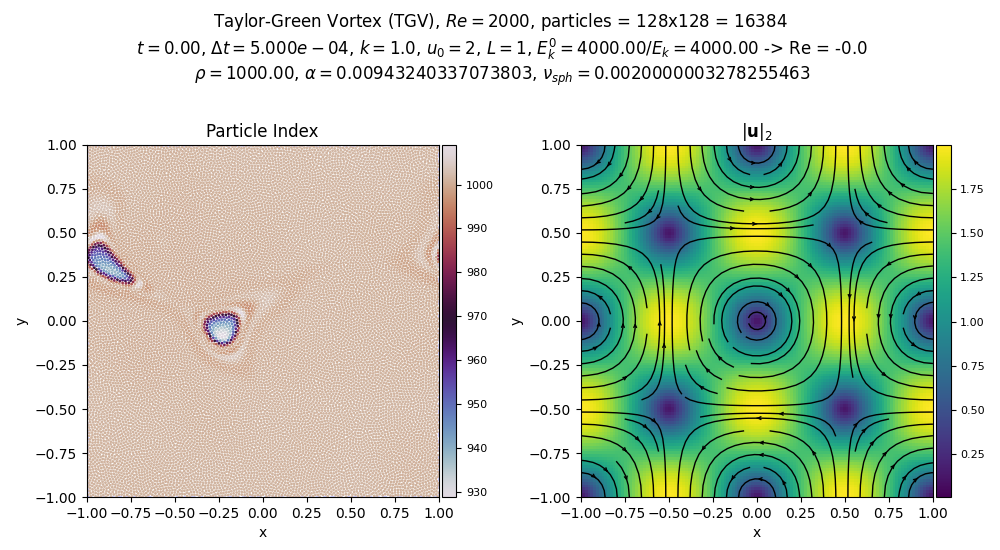

In [18]:
from diffSPH.v2.plotting import updatePlots
from diffSPH.v2.runner import runSimulation, setupSimulation

def callBackFn(perennialState, particleState, config, plotStates, fig, axis, frameStatistics):
    E_k = perennialState['fluid']['E_k']
    nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
    Re = u_mag * 2 / nu_total
    title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {E_k:.2f}$ -> Re = {Re}\n$\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$, $\\alpha = {config["diffusion"]["alpha"]}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$')

config['timestep']['active'] = False
config['timestep']['dt'] = 1e-3
initialState = {
    'fluid': particleState,
    'time': 0.0,
    'timestep': 0,
    'dt': torch.tensor(5e-4, device = config['compute']['device']),
}

from diffSPH.v2.plotting import setupInitialPlot

perennialState = copy.deepcopy(state)
fig, axis, plotStates = setupInitialPlot(state, state, config)
priorState = None

E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
Re = u_mag * 2 / nu_total

title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}\n $\\rho = {particleState["densities"].mean().cpu().detach().numpy():.2f}$, $\\alpha = {config["diffusion"]["alpha"]}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$')
fig.tight_layout()

# updatePlots(perennialState, particleState, config, plotStates, fig, axis)
stats = []

In [19]:

searchNeighbors(perennialState, config)

In [20]:
diva = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', gradientMode='difference', neighborhood=perennialState['fluid']['neighborhood'])

In [21]:
div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)

In [22]:
print(div, diva)

tensor([ 1.1160e+01, -3.6216e-03, -3.1950e-01,  ..., -1.0470e+00,
         7.5616e-01, -3.6498e+00], device='cuda:0') tensor([-1.1280e-02,  3.6098e-06,  3.1897e-04,  ...,  1.0456e-03,
        -7.5520e-04,  3.6443e-03], device='cuda:0')


In [23]:
config['diffusion']['densityScheme'] = 'deltaSPH'

In [24]:
config['shifting']['threshold'] = 0.5
config['diffusion']['pi-switch'] = False
config['diffusion']['alpha'] = 0.01

In [25]:
perennialState['fluid']['densities'][:] = config['fluid']['rho0']

In [26]:
perennialState['fluid']['pressures'] = computeEOS(perennialState['fluid'], config)

In [27]:
priorState = None

In [28]:

perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)

Momentum Term: Mean -  tensor(0.0178, device='cuda:0') Max -  tensor(58.9735, device='cuda:0') Min -  tensor(-56.9326, device='cuda:0') Sum:  tensor(291.6729, device='cuda:0')
Density Term: Mean -  tensor(0., device='cuda:0') Max -  tensor(0., device='cuda:0') Min -  tensor(0., device='cuda:0') Sum:  tensor(0., device='cuda:0')
Momentum Term: Mean -  tensor(0.0583, device='cuda:0') Max -  tensor(59.9479, device='cuda:0') Min -  tensor(-64.2828, device='cuda:0') Sum:  tensor(954.6940, device='cuda:0')
Density Term: Mean -  tensor(-1.5937e-06, device='cuda:0') Max -  tensor(6.6076, device='cuda:0') Min -  tensor(-6.6318, device='cuda:0') Sum:  tensor(-0.0261, device='cuda:0')


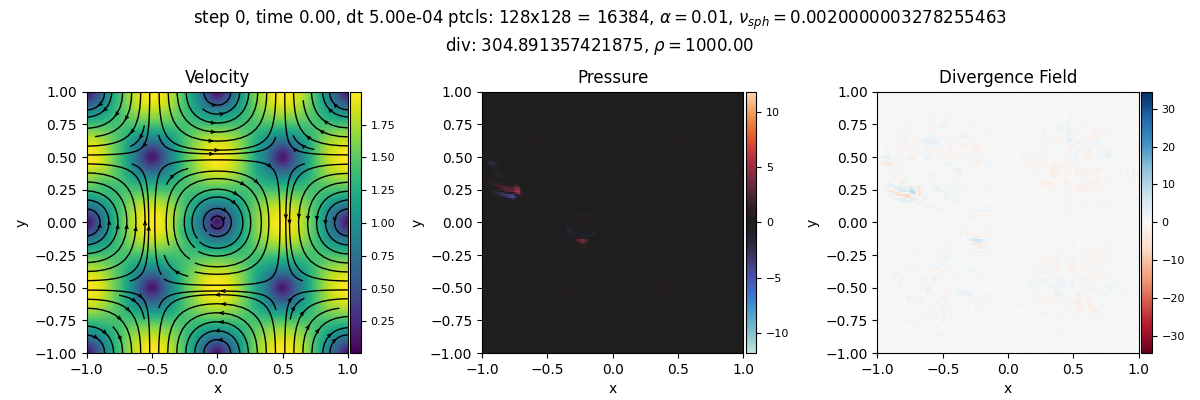

In [29]:
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'velocities',
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=True, cmap = 'viridis', title = 'Velocity', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = True)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'pressures',
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'icefire', streamLines = False, operation = None, title = 'Pressure', plotBoth = False, which = 'fluid', midPoint = 0)

l2Plot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      div,
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = 'Divergence Field', plotBoth = False, which = 'fluid', midPoint = 0)


fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.2f}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum()}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$')

fig.tight_layout()

In [30]:
from diffSPH.v2.plotting import exportPlot, postProcessPlot
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.simulationSchemes.deltaPlus import checkNaN

priorState = None
for i in tqdm(range(2560)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    perennialState['fluid']['shiftAmount'] = dx
    perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]
    if config['compute']['checkNaN']:
        checkNaN(perennialState['fluid']['positions'], 'positions')
        checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    
    # perennialState = simulationStep(perennialState, config)
    # perennialState['fluidGhostParticles'] = buildOutletGhostParticles(regions, perennialState, config)


    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    # fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')
    # perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    perennialState['fluid']['Eks'] = (0.5 * perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = -1)**2)
    perennialState['fluid']['E_k'] = perennialState['fluid']['Eks'].sum().detach().cpu().item()
    frameStatistics = computeStatistics(perennialState, particleState, config)
    
    ttime = perennialState['time'] if not isinstance(perennialState['time'], torch.Tensor) else perennialState['time'].cpu().item()
    stats.append(frameStatistics)

    if i % 16 == 0:
        searchNeighbors(perennialState, config)
        visualizationState = prepVisualizationState(perennialState, config)
        div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)
        
        # div = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', gradientMode='difference', neighborhood=perennialState['fluid']['neighborhood'])
        updatePlot(indexPlot, visualizationState, 'velocities')
        updatePlot(quantPlot, visualizationState, 'pressures')
        # print(div)
        updatePlot(l2Plot, visualizationState, div)
        
        
        fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.2f}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum()}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$')

        
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)



        # callBackFn(perennialState, particleState, config, plotStates, fig, axis, frameStatistics)
        # updatePlots(perennialState, particleState, config, plotStates, fig, axis, title = '')

        # printState(perennialState)
        # print(f'Iteration {i}')
        # visualizationState = prepVisualizationState(perennialState, config)
        # updatePlot(indexPlot, visualizationState, 'densities')
        # updatePlot(quantPlot, visualizationState, 'velocities')
        # fig.canvas.draw()
        # fig.canvas.flush_events()
        # exportPlot(perennialState, config, fig)
    if 'regions' in config and config['regions'] is not None:
        for emitter in config['regions']:
            if emitter['type'] == 'inlet':
                processInlet(perennialState, emitter)
            if emitter['type'] == 'outlet':
                processOutlet(emitter, config, perennialState)
            if emitter['type'] == 'forcing':
                processForcing(emitter, config, perennialState)


  0%|          | 0/2560 [00:00<?, ?it/s]

Momentum Term: Mean -  tensor(0.1006, device='cuda:0') Max -  tensor(94.7985, device='cuda:0') Min -  tensor(-78.5801, device='cuda:0') Sum:  tensor(1647.9341, device='cuda:0')
Density Term: Mean -  tensor(-1.5914e-06, device='cuda:0') Max -  tensor(6.6125, device='cuda:0') Min -  tensor(-6.6334, device='cuda:0') Sum:  tensor(-0.0261, device='cuda:0')
Momentum Term: Mean -  tensor(0.1449, device='cuda:0') Max -  tensor(132.7616, device='cuda:0') Min -  tensor(-117.8444, device='cuda:0') Sum:  tensor(2374.0371, device='cuda:0')
Density Term: Mean -  tensor(-4.9269e-06, device='cuda:0') Max -  tensor(11.3909, device='cuda:0') Min -  tensor(-11.3381, device='cuda:0') Sum:  tensor(-0.0807, device='cuda:0')
Momentum Term: Mean -  tensor(0.1838, device='cuda:0') Max -  tensor(217.8307, device='cuda:0') Min -  tensor(-167.2126, device='cuda:0') Sum:  tensor(3011.6494, device='cuda:0')
Density Term: Mean -  tensor(-4.9232e-06, device='cuda:0') Max -  tensor(11.2563, device='cuda:0') Min -  ten

In [140]:
velocity_diffusion = computeViscosity(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)
velocities = torch.clone(perennialState['fluid']['velocities'])
newState = copy.deepcopy(perennialState)


In [144]:

def computeViscosity(stateA, stateB, neighborhood, config):
    with record_function("[SPH] - Fluid Viscosity [deltaSPH inviscid]"):
        # return viscosityKernel_cpp(
        #     neighborhood['indices'], neighborhood['supports'], neighborhood['kernels'], neighborhood['gradients'], neighborhood['distances'], neighborhood['vectors'], 
        #     stateA['numParticles'],
        #     neighborhood['numNeighbors'],
        #     neighborhood['neighborOffsets'],


        #     (stateA['velocities'], stateB['velocities']), 
        #     (stateA['densities'], stateB['densities']), 
        #     (stateA['masses'], stateB['masses']), 
        #     (stateA['supports'], stateB['supports']), 
        #     config['fluid']['cs'], config['fluid']['rho0'], config['diffusion']['alpha'], config['diffusion']['eps'], config['diffusion']['pi-switch'])

        eps = config['diffusion']['eps']
        alpha = config['diffusion']['alpha']

        (i,j) = neighborhood['indices']
        h_ij = neighborhood['supports']
        v_ij = stateA['velocities'][i] - stateB['velocities'][j]
        r_ij = neighborhood['distances'] * h_ij
        x_ij = neighborhood['vectors'] * r_ij.view(-1,1)
        vr_ij = torch.einsum('ij,ij->i', v_ij, x_ij)

        pi_ij = -vr_ij / (r_ij**2 + eps * h_ij**2)


        rho_ij = (stateA['densities'][i] + stateB['densities'][j]) / 2

        q = pi_ij * stateB['masses'][j] / rho_ij
        kq = q.view(-1,1) * neighborhood['gradients']

        visco = (alpha * stateA['supports'] * config['fluid']['cs'] * config['fluid']['rho0'] / stateA['densities']).view(-1,1)
        visco = (alpha * stateA['supports'] * config['fluid']['cs']).view(-1,1)

        return -visco * scatter_sum(kq, i, dim = 0, dim_size = stateA['numParticles'])

        # if config['diffusion']['pi-switch']:
            # pi_ij = torch.where(vr_ij < 0, pi_ij, 0)

        V_j = stateB['masses'][j] /( stateA['densities'][i] +  stateB['densities'][j])
        # if 'normals' in stateB:
        #     boundaryNormals = stateB['normals'][j]
        #     v_ij_parallel = torch.einsum('ij,ij->i', v_ij, boundaryNormals).view(-1,1) * boundaryNormals
        #     v_ij_orthogonal = v_ij - v_ij_parallel

        #     vr_ij = torch.einsum('ij,ij->i', vr_ij, x_ij)

        #     pi_ij = vr_ij / (r_ij + eps * h_ij**2)
        #     if config['diffusion']['pi-switch']:
        #         pi_ij = torch.where(vr_ij < 0, pi_ij, 0)

        # kq = (V_j * pi_ij).view(-1,1) * neighborhood['gradients']
        viscosityTerm =  (alpha * stateA['supports'] * config['fluid']['cs'] * config['fluid']['rho0'] / stateA['densities']).view(-1,1) * scatter_sum(kq, i, dim = 0, dim_size = stateA['numParticles'])
    


        return viscosityTerm
        # return (alpha * fluidState['fluidSupports'] * config['fluid']['cs'] * config['fluid']['rho0'] / fluidState['densities']).view(-1,1) * scatter_sum(kq, i, dim = 0, dim_size = fluidState['numParticles'])


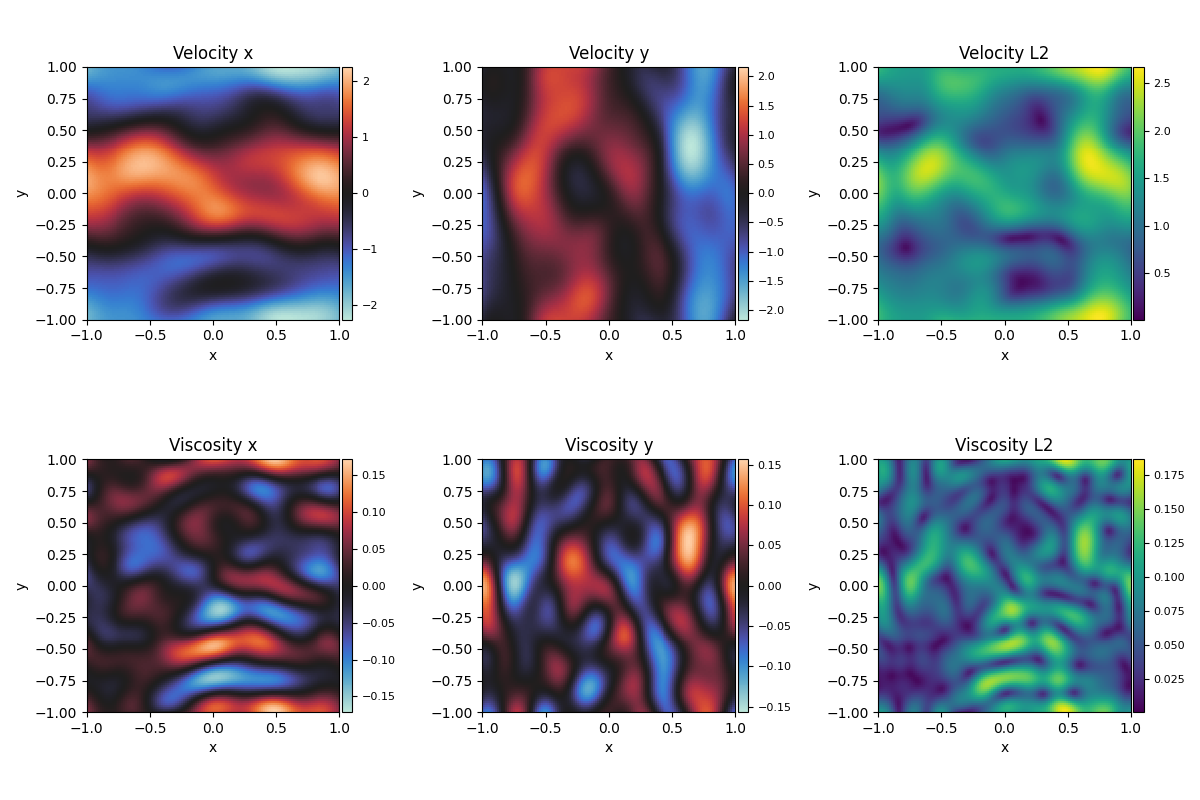

In [145]:
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
fig, axis = plt.subplots(2,3, figsize = (12,8), squeeze = False)

visualizationState = prepVisualizationState(newState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

vel_xPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'velocities',
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'icefire', title = 'Velocity x', which = 'fluid', plotBoth = False, midPoint = 0)
vel_yPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'velocities',
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'icefire', streamLines = False, operation = None, title = 'Velocity y', plotBoth = False, which = 'fluid', midPoint = 0)

vel_plot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      'velocities',
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=True, cmap = 'viridis', streamLines = False, operation = None, title = 'Velocity L2', plotBoth = False, which = 'fluid', midPoint = 0)

visc_xPlot = visualizeParticleQuantity(fig, axis[1,0], config, visualizationState, quantity =
                                      velocity_diffusion,
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'icefire', title = 'Viscosity x', which = 'fluid', plotBoth = False, midPoint = 0)
visc_yPlot = visualizeParticleQuantity(fig, axis[1,1], config, visualizationState, quantity = 
                                      velocity_diffusion,
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'icefire', streamLines = False, operation = None, title = 'Viscosity y', plotBoth = False, which = 'fluid', midPoint = 0)

visc_plot = visualizeParticleQuantity(fig, axis[1,2], config, visualizationState, quantity = 
                                      velocity_diffusion,
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=True, cmap = 'viridis', streamLines = False, operation = None, title = 'Viscosity L2', plotBoth = False, which = 'fluid', midPoint = 0)

fig.tight_layout()

In [146]:
for i in tqdm(range(1024)):
    velocity_diffusion = computeViscosity(newState['fluid'], newState['fluid'], newState['fluid']['neighborhood'], config)
    newState['fluid']['velocities'] += velocity_diffusion * newState['dt'] * 10
    if i%16 == 0:

        print(f'Iteration {i}, {velocity_diffusion.mean()}, {newState["fluid"]["velocities"]}')


        updatePlot(vel_xPlot, visualizationState, newState['fluid']['velocities'])
        updatePlot(vel_yPlot, visualizationState, newState['fluid']['velocities'])
        updatePlot(vel_plot, visualizationState, newState['fluid']['velocities'])

        updatePlot(visc_xPlot, visualizationState, velocity_diffusion)
        updatePlot(visc_yPlot, visualizationState, velocity_diffusion)
        updatePlot(visc_plot, visualizationState, velocity_diffusion)

    
        fig.canvas.draw()
        fig.canvas.flush_events()

  0%|          | 0/1024 [00:00<?, ?it/s]

Iteration 0, 0.0, tensor([[-1.7855, -0.2661],
        [-1.7490, -0.1981],
        [-1.7132, -0.1426],
        ...,
        [-1.8752, -0.5003],
        [-1.8408, -0.4007],
        [-1.8058, -0.3103]], device='cuda:0')
Iteration 16, 4.656612873077393e-10, tensor([[-1.7808, -0.2722],
        [-1.7449, -0.2047],
        [-1.7096, -0.1494],
        ...,
        [-1.8690, -0.5042],
        [-1.8351, -0.4058],
        [-1.8006, -0.3163]], device='cuda:0')
Iteration 32, 2.3283064365386963e-10, tensor([[-1.7762, -0.2783],
        [-1.7408, -0.2112],
        [-1.7061, -0.1561],
        ...,
        [-1.8629, -0.5081],
        [-1.8294, -0.4108],
        [-1.7955, -0.3222]], device='cuda:0')
Iteration 48, 0.0, tensor([[-1.7716, -0.2842],
        [-1.7367, -0.2176],
        [-1.7025, -0.1626],
        ...,
        [-1.8569, -0.5119],
        [-1.8239, -0.4156],
        [-1.7905, -0.3280]], device='cuda:0')
Iteration 64, 0.0, tensor([[-1.7671, -0.2900],
        [-1.7328, -0.2238],
        [-1.6991,

In [70]:
print(div)

tensor([-0.0034,  0.0015, -0.0005,  ...,  0.0049,  0.0038, -0.0013],
       device='cuda:0')


In [71]:
from diffSPH.v2.plotting import exportPlot, postProcessPlot
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.simulationSchemes.deltaPlus import checkNaN

priorState = None
for i in tqdm(range(2560)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    perennialState['fluid']['shiftAmount'] = dx
    perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]
    if config['compute']['checkNaN']:
        checkNaN(perennialState['fluid']['positions'], 'positions')
        checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    
    # perennialState = simulationStep(perennialState, config)
    # perennialState['fluidGhostParticles'] = buildOutletGhostParticles(regions, perennialState, config)


    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    # fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')
    # perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    perennialState['fluid']['Eks'] = (0.5 * perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = -1)**2)
    perennialState['fluid']['E_k'] = perennialState['fluid']['Eks'].sum().detach().cpu().item()
    frameStatistics = computeStatistics(perennialState, particleState, config)
    
    ttime = perennialState['time'] if not isinstance(perennialState['time'], torch.Tensor) else perennialState['time'].cpu().item()
    stats.append(frameStatistics)

    if i % 16 == 0:
        searchNeighbors(perennialState, config)
        visualizationState = prepVisualizationState(perennialState, config)
        div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)
        
        # div = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', gradientMode='difference', neighborhood=perennialState['fluid']['neighborhood'])
        updatePlot(indexPlot, visualizationState, 'velocities')
        updatePlot(quantPlot, visualizationState, 'densities')
        # print(div)
        updatePlot(l2Plot, visualizationState, div)
        
        
        fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.2f}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum()}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$')

        
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)



        # callBackFn(perennialState, particleState, config, plotStates, fig, axis, frameStatistics)
        # updatePlots(perennialState, particleState, config, plotStates, fig, axis, title = '')

        # printState(perennialState)
        # print(f'Iteration {i}')
        # visualizationState = prepVisualizationState(perennialState, config)
        # updatePlot(indexPlot, visualizationState, 'densities')
        # updatePlot(quantPlot, visualizationState, 'velocities')
        # fig.canvas.draw()
        # fig.canvas.flush_events()
        # exportPlot(perennialState, config, fig)
    if 'regions' in config and config['regions'] is not None:
        for emitter in config['regions']:
            if emitter['type'] == 'inlet':
                processInlet(perennialState, emitter)
            if emitter['type'] == 'outlet':
                processOutlet(emitter, config, perennialState)
            if emitter['type'] == 'forcing':
                processForcing(emitter, config, perennialState)


  0%|          | 0/2560 [00:00<?, ?it/s]

q_ij: -6.103515625e-05 [-4.57763671875e-05, -3.4332275390625e-05], k: 27.15625 [0.0, 0.0], kq: -0.0419921875 [-0.125, 0.0625], div: 0.11322127282619476
Momentum Term: Mean -  tensor(6.9105e-06, device='cuda:0') Max -  tensor(0.0130, device='cuda:0') Min -  tensor(-0.0128, device='cuda:0') Sum:  tensor(0.1132, device='cuda:0')
Density Term: Mean -  tensor(0., device='cuda:0') Max -  tensor(0., device='cuda:0') Min -  tensor(0., device='cuda:0') Sum:  tensor(0., device='cuda:0')
q_ij: 3.0517578125e-05 [1.52587890625e-05, 3.4332275390625e-05], k: -2.453125 [2.5, -0.78125], kq: -57466.68359375 [-27965.5, -29501.1875], div: 57466.609375
Momentum Term: Mean -  tensor(3.5075, device='cuda:0') Max -  tensor(1249.3936, device='cuda:0') Min -  tensor(-1649.3831, device='cuda:0') Sum:  tensor(57466.6094, device='cuda:0')
Density Term: Mean -  tensor(0., device='cuda:0') Max -  tensor(0., device='cuda:0') Min -  tensor(0., device='cuda:0') Sum:  tensor(0., device='cuda:0')
q_ij: 0.0001220703125 [8

KeyboardInterrupt: 

In [17]:
perennialState['fluid']['neighborhood']

KeyError: 'neighborhood'

In [28]:
perennialState['fluid']['neighborhood']['vectors']
for i in tqdm(range(perennialState['fluid']['numParticles'])):
    numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors'][i]
    offset = perennialState['fluid']['neighborhood']['neighborOffsets'][i]

    # print(f'Particle {i} has {numNeighbors} neighbors')
    for j in range(numNeighbors):
        index_j = perennialState['fluid']['neighborhood']['indices'][1][offset + j]
        index_i = perennialState['fluid']['neighborhood']['indices'][0][offset + j]

        numNeighbors_j = perennialState['fluid']['neighborhood']['numNeighbors'][index_j]
        offsets_j = perennialState['fluid']['neighborhood']['neighborOffsets'][index_j]

        for k in range(numNeighbors_j):
            index_k = perennialState['fluid']['neighborhood']['indices'][1][offsets_j + k]
            if index_k == i:

                # print(f'{index_i} - {index_j} - {index_k} -> {offset + i} - {offset + j} - {offsets_j + k}')

                vectors_k = perennialState['fluid']['neighborhood']['vectors'][offsets_j + k]
                vectors_j = perennialState['fluid']['neighborhood']['vectors'][offset + j]

                # print(f'Vector {k} of particle {index_j} is {vectors_j} and {vectors_k}')

                # print(f'Neighbor {index_k} is particle {index_i} and vice versa')
                if torch.any(vectors_j != -vectors_k):
                    print(f'Vector {k} of particle {index_j} is {vectors_j} and {vectors_k}')
                break
        # print(f'Neighbor {j} is particle {perennialState["fluid"]["neighborhood"]["indices"][0][offset + j]}')

    # break

  0%|          | 0/16384 [00:00<?, ?it/s]

In [31]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

CompletedProcess(args=['ffmpeg', '-loglevel', 'warning', '-hide_banner', '-y', '-i', 'output/2024_07_03-13_40_36/output.mp4', '-i', 'output/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_07_03-13_40_36.gif'], returncode=0)